## Нач значения


In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numba import jit, njit, prange
import csv
from tqdm import tqdm
import pandas as pd
import json


# Физические константы
class Constants:
    G = 6.67e-11  # гравитационная постоянная
    M1 = 2.0e30   # масса звезды (кг)
    M2 = 5.7e26   # масса планеты (кг)
    M3 = 1.4e23   # масса спутника (кг)
    R1 = 696340e3 # радиус звезды (м)
    R2 = 60270e3   # радиус планеты (м)
    R3 = 2575e3   # радиус спутника (м)
    R12 = 1429e9   # начальное расстояние звезда-планета (м)
    R23 = 1222e6   # начальное расстояние планета-спутника (м)
    U2 = 9.7e3     # начальная скорость планеты (м/с)
    U3 = 5.57e3   # начальная скорость спутника (м/с)
    T = 4100.0    # время работы двигателя (с)
    H = 1000e3     # высота орбиты (м)
    M0 = 95.0     # масса полезной нагрузки (кг)
    U = 2500.0    # скорость истечения (м/с)
    koef = 0.001

In [125]:
@njit
def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

@njit
def calculate_forces(t, y):
    r12x, r12y, r13x, r13y = y[0], y[1], y[2], y[3]
    v2x, v2y, v3x, v3y = y[4], y[5], y[6], y[7]

    # Расчёт расстояний
    r12 = np.sqrt(r12x ** 2 + r12y ** 2)      # расстояние от планеты до солнца
    r13 = np.sqrt(r13x ** 2 + r13y ** 2)     # расстояние от спутника до солнца
    r23 = distance(r13x, r13y, r12x, r12y)   # расстояние от спутника до планеты

    # Ускорения для спутника
    f3x = (
        - Constants.G * Constants.M1 * r13x / r13  ** 3
           - Constants.G * Constants.M2 * (r13x - r12x) / r23 ** 3)
    f3y = (
        - Constants.G * Constants.M1 * r13y / r13 ** 3
        - Constants.G * Constants.M2 * (r13y - r12y) / r23 ** 3)

    # Ускорение для планеты
    f2x = (- Constants.G * Constants.M1 * r12x/ r12 ** 3
           + Constants.G * Constants.M3 *  (r13x - r12x) / r23 ** 3)

    f2y = (- Constants.G * Constants.M1 * r12y/ r12 ** 3
           + Constants.G * Constants.M3 *  (r13y - r12y) / r23 ** 3)

    return [v2x, v2y, v3x, v3y, f2x, f2y , f3x, f3y ]

In [38]:
# положение планеты в начальный момент времени
r12x0 = Constants.R1 + Constants.R12 + Constants.R2
r12y0 = 0
v2x0 = 0
v2y0 = Constants.U2

# положение спутника  в начальный момент времени
r13x0 = Constants.R1 + Constants.R12 + Constants.R2 * 2 + Constants.R23 + Constants.R3
r13y0 = 0
v3x0 = 0
v3y0 = Constants.U2 + Constants.U3

mt = 0
y0 = [r12x0, r12y0, r13x0, r13y0,  v2x0, v2y0, v3x0, v3y0]

t0 = 0.0
t_end = int(60 * 60 * 24 * 10759 )
t_span = (0, t_end)

dt = 40000
t_eval = np.arange(0, t_end, dt)


sol = integrate.solve_ivp(
    calculate_forces,
    (t0, t_end),
    y0,
    method='DOP853',
    t_eval=t_eval,
    rtol=1e-5,
    atol=1e-5,
    vectorized=True
)

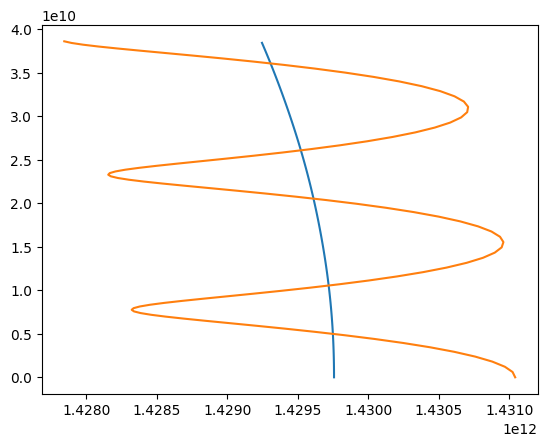

In [40]:
solution = sol.y[:,:100]

plt.plot(solution[0],solution[1])
plt.plot(solution[2],solution[3])

## Нач положение корабля

In [2]:
r12y0, r12x0 = 0 , Constants.R1 + Constants.R12 + Constants.R2
v2x0, v2y0 = 0, Constants.U2
r13y0, r13x0 = 0, Constants.R1 + Constants.R12 + Constants.R2 * 2 + Constants.R23 + Constants.R3
v3x0, v3y0 = 0, Constants.U2 + Constants.U3
r12x,r12y= r12x0,r12y0

In [3]:
# Вспомогательные функции

def m(t, mt) -> np.float64:
    if t >= Constants.T:
        return Constants.M0
    else:
        return (Constants.M0 + mt) / (1 - Constants.koef) - (mt * t) / Constants.T

def dm(t, mt) -> np.float64:
    if t > Constants.T:
        return 0.0
    else:
        return -mt / Constants.T
@njit
def distance(x1, y1, x2, y2) -> np.float64:
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calculate_forces(t, y, mt):
    rx, ry, r13x, r13y = y[0], y[1], y[2], y[3]
    vx, vy, v3x, v3y = y[4], y[5], y[6], y[7]
    r12x, r12y, v2x, v2y=r12x0, r12y0, y[10], y[11]

    # Расчёт расстояний
    r = np.sqrt(rx ** 2 + ry ** 2)           # расстояние от солнца до ракеты
    r2 = distance(rx, ry, r12x, r12y)        # расстояние от ракеты до планеты
    r3 = distance(rx, ry, r13x, r13y)        # расстояние от ракеты до спутника
    r12 =np.sqrt(r12x ** 2 + r12y ** 2)
    r13 = np.sqrt(r13x ** 2 + r13y ** 2)     # расстояние от спутника до солнца
    r23 = distance(r13x, r13y, r12x, r12y)   # расстояние от спутника до планеты

    v = np.sqrt(vx ** 2 + vy ** 2)
    f_rocket_x = -(Constants.U * dm(t, mt) * vx) / (v * m(t, mt))
    f_rocket_y = -(Constants.U * dm(t, mt) * vy) / (v * m(t, mt))

    f_gravity_x = Constants.G * (
        - Constants.M1 * rx / r ** 3
        - Constants.M2 * (rx - r12x) / r2 ** 3 - Constants.M3 * (rx - r13x) / r3 ** 3)
    f_gravity_y = Constants.G * (
        - Constants.M1 * ry / r ** 3
        - Constants.M2 * (ry - r12y) / r2 ** 3 - Constants.M3 * (ry - r13y) / r3 ** 3)

    # Ускорения для ракеты
    fx = f_rocket_x + f_gravity_x
    fy = f_rocket_y + f_gravity_y

    # Ускорения для спутника
    f3x = (
        # - Constants.G * Constants.M1 * r13x / r13  ** 3
           - Constants.G * Constants.M2 * (r13x - r12x) / r23 ** 3)
    f3y = (
        # - Constants.G * Constants.M1 * r13y / r13 ** 3
        - Constants.G * Constants.M2 * (r13y - r12y) / r23 ** 3)

    # Ускорение для планеты
    f2x = (- Constants.G * Constants.M1 * r12x/ r12 ** 3
           + Constants.G * Constants.M3 *  (r13x - r12x) / r23 ** 3)

    f2y = (- Constants.G * Constants.M1 * r12y/ r12 ** 3
           + Constants.G * Constants.M3 *  (r13y - r12y) / r23 ** 3)

    return np.array([vx, vy, v3x, v3y, fx, fy, f3x, f3y, v2x, v2y, f2x, f2y],dtype=np.float64)

In [4]:
def collision_event(t, y, mt):
    rx, ry, r3x, r3y, _, _, _, _, _, _, _, _= y
    distance = np.sqrt((rx - r3x)**2 + (ry - r3y)**2)
    return distance - Constants.R3
collision_event.terminal = True

In [5]:
def integrate_trajectory(angle, mt, output=False):
    _angle = np.radians(angle)  # угол в радианах

    v3x = v3x0 - v2x0
    v3y = v3y0 - v2y0

    r12x = r12x0
    r12y = r12y0

    r3x = r13x0 - r12x
    r3y = r13y0 - r12y
    r3 = np.sqrt(r3x ** 2 + r3y ** 2)

    v0 = np.sqrt(Constants.G * Constants.M2 / (Constants.R2 + Constants.H))
    rx0 = (Constants.R2 + Constants.H) * (r3x * np.cos(_angle) - r3y * np.sin(_angle)) / r3
    ry0 = (Constants.R2 + Constants.H) * (r3x * np.sin(_angle) + r3y * np.cos(_angle)) / r3

    r0 = np.sqrt(rx0 ** 2 + ry0 ** 2)

    vx0 = -v0 * ry0 / r0
    vy0 = v0 * rx0 / r0

    rx0 += r12x0
    ry0 += r12y0

    y0 = [rx0, ry0, r13x0, r13y0, vx0, vy0, v3x, v3y,r12x0,r12y0,v2x0,v2y0]

    t0 = 0.0
    t_end = int(60 * 60 * 24 * 19 * 1.4)
    t_span = (0, t_end)
    t_eval = np.linspace(0, t_end, t_end // 4 )

    sol = integrate.solve_ivp(
      calculate_forces,
      t_span,
      y0,
      method='RK45',
      t_eval=t_eval,
      rtol=1e-12,
      atol=1e-12,
      events=collision_event,  # закоментировать для оптимизации
      args = (mt,)
  )

    if output:
        np.savetxt(f'trajectory_mt-{mt}_angle-{angle}.csv', np.column_stack([sol.y[0], sol.y[1], sol.y[2], sol.y[3]]), delimiter=" ", header="x y x3 y3", comments="")

    return sol

In [119]:
_mt = 5242
angle = 69.5

solution = integrate_trajectory(angle, _mt, output=True)

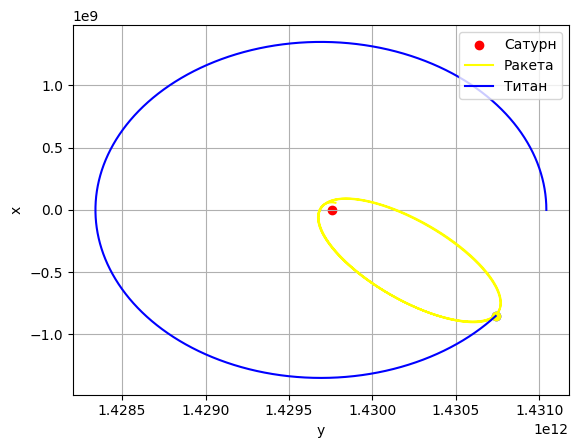

In [120]:
sol = solution.y
plt.scatter(r12x,r12y,label='Сатурн',color='red')
plt.plot(sol[0],sol[1], label='Ракета',color='yellow')
plt.plot(sol[2],sol[3], label='Титан',color='blue')
plt.scatter(sol[2][-1],sol[3][-1],color='blue')
plt.scatter(sol[0][-1],sol[1][-1],color='yellow')


plt.xlabel('y')
plt.ylabel('x')
plt.legend(loc='best')
plt.grid()
plt.show()

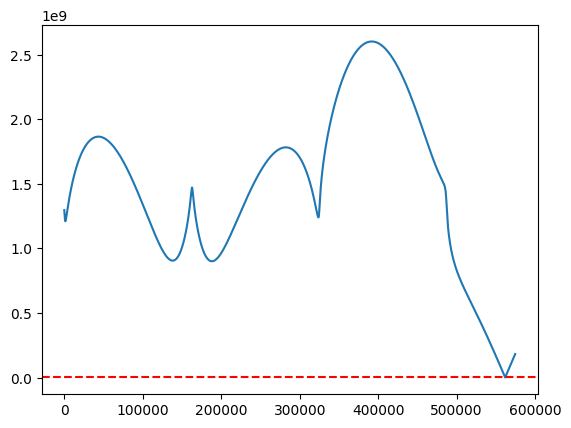

In [196]:
plt.plot(distance(sol[0],sol[1],sol[2],sol[3]))
plt.axhline(y = Constants.R3,color='r', linestyle='--' )
# plt.ylim(0,5e6)

In [106]:
def save_to_csv(data, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Angle", "MT"])
        writer.writerows(data)

def save_min_dist(data, filename):
    converted_data = [(angle, [(float(mt), float(dist)) for mt, dist in curr_dist]) for angle, curr_dist in data]
    with open(filename, 'w') as f:
        json.dump(converted_data, f, indent=4)
        
def plot_min_dist_time(data):
    plt.plot(distance(data[0],data[1],data[2],data[3]))
    plt.axhline(y = Constants.R3,color='r', linestyle='--' ) 
    plt.show()
        
def plot_min_dist_mt(filename):
    with open(filename, 'r') as f:
        MIN_DIST = json.load(f)
    
    for angle, curr_dist in MIN_DIST:
        mt_values = [mt for mt, dist in curr_dist]
        dist_values = [dist for mt, dist in curr_dist]

        plt.figure(figsize=(8, 5))
        plt.plot(mt_values, dist_values)
        plt.scatter(mt_values[-1], dist_values[-1] - 1e4)
        plt.axhline(y=Constants.R3, color = 'r')
        plt.xlabel('Кол-во топлива')
        plt.ylabel('Минимальное расстояние')
        plt.title(f'График зав-ти минимального расстояния от кол-ва топлива для угла: {angle}')
        plt.grid(True)
        plt.ylim(1e6,5e6)
        plt.show()

In [84]:
MT_MIN = []
MIN_DIST = []
for _angle in np.arange(321 ,322, 1):
    CURR_DIST = []
    for _mt in tqdm(np.arange(5350, 6100, 1), desc=f"Angle {_angle}"):
        solution = integrate_trajectory(_angle, _mt, output=False)
        sol = solution.y
        CURR_DIST.append((float(_mt) , float(min(distance(sol[0],sol[1],sol[2],sol[3])))))
        if solution.t_events[0].size > 0:
            print(f'boom: {_mt}', end='\r')
            MT_MIN.append((_angle,_mt))
            break
    MIN_DIST.append((int(_angle), CURR_DIST))

Angle 321:   5%|▍         | 36/750 [00:28<09:28,  1.26it/s]

In [79]:
save_to_csv(MT_MIN,'result_accuracity_new.csv')

In [18]:
converted_data = [(int(angle), [(float(mt), float(dist)) for mt, dist in curr_dist]) for angle, curr_dist in MIN_DIST]

In [85]:
save_min_dist(MIN_DIST,'result_min_dist_309_.json')

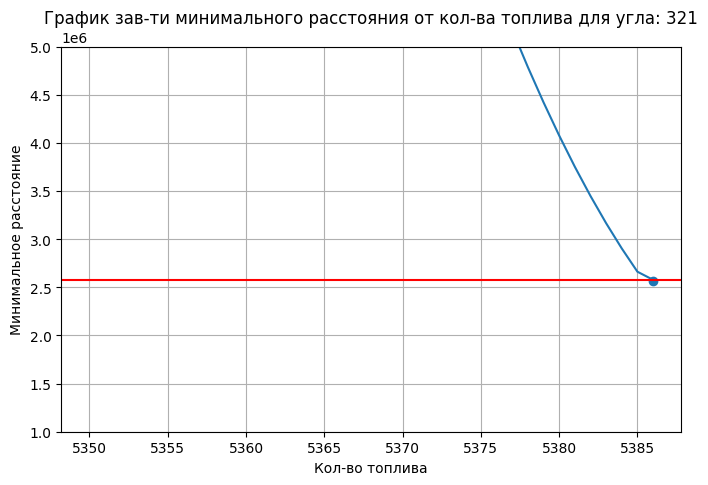

In [113]:
plot_min_dist_mt('result/result_min_dist_321.json')

5242.0

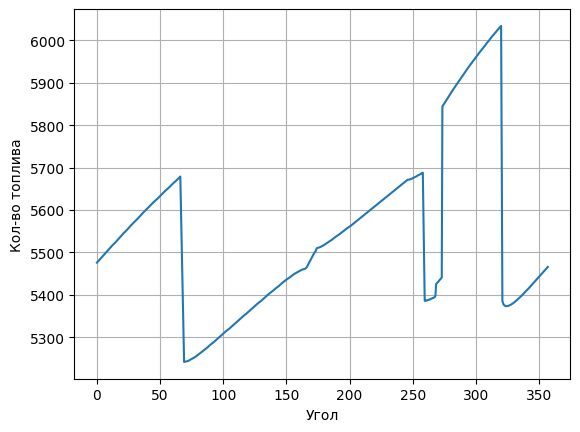

In [83]:
data=pd.read_csv('result/result_new.csv',sep=',')
plt.plot(data.Angle,data.MT)
plt.grid()
plt.xlabel('Угол')
plt.ylabel('Кол-во топлива')
min(data.MT)